# Classificazione Audio: *Transfer Learning con ResNet50*

## Set Up ambiente

In [ ]:
#----- set tf version and install packages
!pip install tensorflow==2.1
!pip install -q keras==2.3.0

     |████████████████████████████████| 421.8 MB 20 kB/s 
     |████████████████████████████████| 3.8 MB 51.0 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 448 kB 70.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=a9e03f499bf0092e9d841fe38b638d3ccd0135e1b40981680a7c249f4cfdb369
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from keras.applications.resnet50 import ResNet50

from keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop, Nadam, SGD
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import tarfile
from time import time
from shutil import copyfile

Using TensorFlow backend.


## Data Preprocessing

In questa sezione si preaparano i dati per l'addestramento del modello:

In [ ]:
root = '/content/gdrive/.shortcut-targets-by-id/1MjIC4GU8uPRRghppoEoRRIAHwGaHj-C8/Progetto_DSIM/dati/SPETTROGRAMMA'

Si processano i dataset di train e test già splittati nel prcedente notebook, al fine di prepareli per l'addestramento:

In [ ]:
# train processing
train_processing = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

train_generator = train_processing.flow_from_directory(root+'/train2',
                        target_size = (224, 224),
                        color_mode = 'rgb',
                        class_mode = 'categorical',
                        batch_size = 32,
                        shuffle = True,
                        seed = 1)

Found 4962 images belonging to 6 classes.


In [ ]:
# test processing
test_processing = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)
test_generator = test_processing.flow_from_directory(root+'/test2',
                        target_size = (224, 224),
                        color_mode = 'rgb',
                        class_mode = 'categorical',
                        batch_size = 32,
                        shuffle = True,
                        seed = 1)

## CNN: ResNet50

In questa sezione si è implementata una rete con una tecnica di transfer learning (fine tuning), utilizzando la rete preaddestrata ResNet50. La scelta di quest'ultima è stata presa dopo aver valutato la rete con perfomance migliori tra quest'ultima e la MobileNet.
Si riporta di seguito solo la rete che ha ottenuto le performance migliori:

Si definisce la funzione di estrazione delle featuers utillizzando la rete preaddestrata:

In [ ]:
def extract_features(data):

  
  base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (224, 224, 3),
                   pooling='avg')

  for layer in base_model.layers:
    layer.trainable = False

  
  dims = []
  for dim in base_model.output_shape:
    if dim == None:
      pass
    else:
      dims.append(dim)
  reshaping = np.prod(np.array(dims))
  
  

  labels = []
  for index in range(len(data)):
    labels.append(data[index][1])

  labels = np.vstack(labels)
  features = base_model.predict_generator(data, verbose = 1)
  features = features.reshape((features.shape[0], reshaping))
  
  print("\nDims features {}\nDims labels {}".format(features.shape, labels.shape))

  del dims, reshaping, base_model

  return features, labels

Si applica la funzione appena descritta al train e test generator e si salvano le informazioni estratte:

In [ ]:
train_features, train_labels = extract_features(train_generator)
np.savez(os.path.join(root, "resnet50col.npz"), features = train_features, labels = train_labels)

np.save(root+"/labelscol.npy", train_generator.class_indices, allow_pickle = True)

print("ResNet50 on the training set has been saved")

In [ ]:
test_features, test_labels = extract_features(test_generator)
np.savez(os.path.join(root, "resnet50col_test.npz"), features = test_features, labels = test_labels)

print("ResNet50 on the test set has been saved")

78/78 [==============================] - 556s 7s/step

Dims features (2480, 2048)
Dims labels (2480, 6)
ResNet50 on the test set has been saved


Si definisce e si caricano i dati appena salvati:

In [ ]:
def info_import(model_train, model_test):
  with np.load(os.path.join(root, model_train)) as data:
    x_train = data['features']
    y_train = data['labels']
    
  with np.load(os.path.join(root, model_test)) as data:
    x_test = data['features']
    y_test = data['labels']
  
  labels = np.load(root+"/labelscol.npy", allow_pickle = True)
  print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
  return x_train, x_test, y_train, y_test, labels

In [ ]:
x_train, x_test, y_train, y_test, labels = info_import("resnet50col.npz","resnet50col_test.npz")

(4962, 2048) (2480, 2048) (4962, 6) (2480, 6)


Si definisce la rete/classificatore in coda alla rete preaddestrata composto come segue:
- Strato di DropOut;
- Strato fullyconnect con 1024 neuroni e funzione di attivazione "relu";
- Strato di DropOut;
- Strato fullyconnect con 512 neuroni e funzione di attivazione "relu";
- Strato di DropOut;
- Strato di output con le 7 classi/neuroni di output e funzione di attivazione "softmax".

In [ ]:
inputs = Input(shape = (x_train.shape[1],))
drop = Dropout(.3)(inputs)
x = Dense(1024, activation = 'relu')(drop)
drop = Dropout(.4)(x)
x = Dense(512, activation='relu')(drop)
drop = Dropout(.3)(x)
outputs = Dense(y_train.shape[1],activation = 'softmax')(drop)

In [ ]:
net = Model(inputs = inputs, outputs = outputs)

# Print some high-level summaries
net.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 2048)              0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_31 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_32 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 6)                 307

La funzione di Loss che si vuole ottimizzare è la "categorical_crossentropy", la tecnica di ottimizzazione è la adam e la metrica scelta è l'accuracy:

In [ ]:
net.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.0001), metrics=['accuracy'])

si addestra il modello con 130 epoche e con un batch di 128:

In [ ]:
epochs = 130
batch_size = 128
network_history = net.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test))

Train on 4962 samples, validate on 2480 samples
Epoch 1/130
4962/4962 [==============================] - 3s 585us/step - loss: 2.0088 - accuracy: 0.2090 - val_loss: 1.6015 - val_accuracy: 0.3802
Epoch 2/130
4962/4962 [==============================] - 3s 548us/step - loss: 1.7392 - accuracy: 0.2793 - val_loss: 1.5385 - val_accuracy: 0.3863
Epoch 3/130
4962/4962 [==============================] - 3s 553us/step - loss: 1.6425 - accuracy: 0.3261 - val_loss: 1.4954 - val_accuracy: 0.3875
Epoch 4/130
4962/4962 [==============================] - 3s 558us/step - loss: 1.5841 - accuracy: 0.3458 - val_loss: 1.4600 - val_accuracy: 0.4137
Epoch 5/130
4962/4962 [==============================] - 3s 551us/step - loss: 1.5461 - accuracy: 0.3595 - val_loss: 1.4475 - val_accuracy: 0.4226
Epoch 6/130
4962/4962 [==============================] - 3s 548us/step - loss: 1.5436 - accuracy: 0.3642 - val_loss: 1.4187 - val_accuracy: 0.4339
Epoch 7/130
4962/4962 [==============================] - 3s 545us/step

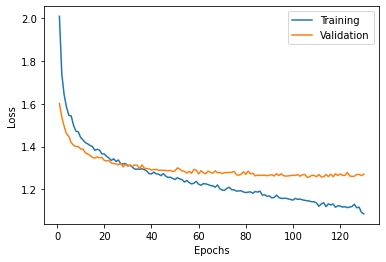

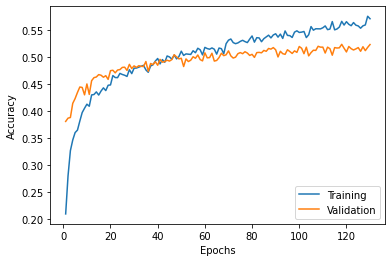

In [ ]:
# plotting
x_plot = list(range(1,epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

In [ ]:
# classification report
y_pred = net.predict(x_test)
y_pred = np.argmax(y_pred, axis = -1)

print(classification_report(np.argmax(y_test, axis = -1),
                            y_pred,
                            target_names = labels.all().keys()))

y_pred = net.predict(x_test)

              precision    recall  f1-score   support

         ANG       0.75      0.61      0.67       426
         DIS       0.57      0.38      0.46       425
         FEA       0.43      0.47      0.45       423
         HAP       0.46      0.58      0.52       424
         NEU       0.51      0.50      0.50       359
         SAD       0.49      0.58      0.54       423

    accuracy                           0.52      2480
   macro avg       0.54      0.52      0.52      2480
weighted avg       0.54      0.52      0.52      2480



Le prestazioni del modello sono buone, non eccezionali. Si può infatti notare che la curva Loss di training non ha una decrescita così netta, mentre nel grafico dell'accuracy si registra un leggera divergenza (overfitting) delle due curve in concomitanza delle ultime epoche. 
L'accuracy complessiva raggiunge il valore di 0.52, trainata dall'ottimo riconoscimento del target "Angry" come già osservato in altri modelli provati in precedenza.
Queste prestazioni segnalano delle difficoltà del modello nell'estrarre delle features in grado di distinguere con precisione le emozioni a partire dagli spettrogrammi. Ciononostante, il comportamento del modello sui dati di test è risultato essere più soddisfacente rispetto a quello degli altri.

## Salvataggio

In [ ]:
import pickle
filename = 'ResNet50Finale.sav'
pickle.dump(net, open(filename, 'wb'))
!cp ResNet50Finale.sav '/content/gdrive/.shortcut-targets-by-id/1MjIC4GU8uPRRghppoEoRRIAHwGaHj-C8/Progetto_DSIM/dati/SPETTROGRAMMA/ResNet50Finale.sav'